# Face Recognition — DeiT + MediaPipe preprocessing
Notebook ini meniru tahapan `klasifikasi_makanan.ipynb` (setup, konfigurasi hyperparameter, tuning grid kecil, pelatihan ulang, evaluasi, dan inference) namun seluruh citra tetap melalui preprocessing MediaPipe (deteksi + crop ter-align + CLAHE/bilateral filter).

Notebook ini juga menyediakan helper inferensi untuk memvisualisasikan bounding box dan label hasil prediksi terbaik.


## Setup dependensi
Set `INSTALL_DEPENDENCIES = True` hanya jika menjalankan di lingkungan baru tanpa PyTorch/timm/albumentations/MediaPipe. Secara default sel ini dilewati.


In [12]:
%pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [13]:
INSTALL_DEPENDENCIES = True

if INSTALL_DEPENDENCIES:
    import subprocess, sys

    subprocess.check_call([
        sys.executable,
        '-m',
        'pip',
        'install',
        '--extra-index-url',
        'https://download.pytorch.org/whl/cpu',
        'torch',
        'torchvision',
        'torchaudio',
    ])

    subprocess.check_call([
        sys.executable,
        '-m',
        'pip',
        'install',
        'timm==0.9.12',
        'torchinfo',
        'albumentations==1.3.1',
        'opencv-python',
        'matplotlib',
        'seaborn',
        'scikit-learn',
        'Pillow',
        'pillow-heif',
    ])

## Import & konfigurasi dasar
Memuat library utama, fungsi helper `set_seed`, serta inisialisasi device serupa dengan notebook klasifikasi makanan.


In [14]:
# ===== Import & Konfigurasi =====
import os, random, math, time, json, copy
from pathlib import Path

import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
from torchinfo import summary

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

plt.style.use('seaborn-v0_8')

try:
    import pillow_heif
    pillow_heif.register_heif_opener()
except ImportError:
    pillow_heif = None


# Utility: set seluruh seed agar eksperimen reprodusibel
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


SEED = 42
set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

CLASS_NAMES = []
label_to_idx = {}
idx_to_label = {}


## Konfigurasi dasar & ruang hyperparameter
Mengikuti struktur `BASE_CFG` + `HP_SPACE` dari notebook klasifikasi makanan, tetapi dengan opsi tambahan terkait dataset wajah/MediaPipe.


In [15]:
# ===== Konfigurasi dasar & kandidat hyperparameter untuk tuning =====
BASE_CFG = {
    "data_root": "dataset-train/train",
    "img_size": 224,
    "max_people": None,
    "max_images_per_person": None,
    "epochs": 15,
    "warmup_epochs": 3,
    "num_workers": 0,
    "save_path": "face_deit_best.pth",
    "mediapipe_model": 1,
    "mediapipe_min_conf": 0.7,
    "mediapipe_bbox_margin": 0.2,
}

# Grid hyperparameter kecil agar waktu tuning wajar
HP_SPACE = {
    "arch": ["deit_tiny_patch16_224", "deit_small_patch16_224"],
    "batch_size": [16, 32],
    "optimizer": ["adamw", "sgd"],
    "lr": [3e-4, 5e-4],
    "weight_decay": [0.01, 0.05],
    "momentum": [0.9],
    "aug": [
        {"rrc_scale": (0.85, 1.0), "hflip": 0.5, "cj": (0.2, 0.2, 0.2, 0.0), "rotate": 10},
        {"rrc_scale": (0.75, 1.0), "hflip": 0.5, "cj": (0.3, 0.3, 0.3, 0.05), "rotate": 15},
    ],
}

print(json.dumps(BASE_CFG, indent=2))
print(json.dumps(HP_SPACE, indent=2))


{
  "data_root": "dataset-train/train",
  "img_size": 224,
  "max_people": null,
  "max_images_per_person": null,
  "epochs": 15,
  "warmup_epochs": 3,
  "num_workers": 0,
  "save_path": "face_deit_best.pth",
  "mediapipe_model": 1,
  "mediapipe_min_conf": 0.7,
  "mediapipe_bbox_margin": 0.2
}
{
  "arch": [
    "deit_tiny_patch16_224",
    "deit_small_patch16_224"
  ],
  "batch_size": [
    16,
    32
  ],
  "optimizer": [
    "adamw",
    "sgd"
  ],
  "lr": [
    0.0003,
    0.0005
  ],
  "weight_decay": [
    0.01,
    0.05
  ],
  "momentum": [
    0.9
  ],
  "aug": [
    {
      "rrc_scale": [
        0.85,
        1.0
      ],
      "hflip": 0.5,
      "cj": [
        0.2,
        0.2,
        0.2,
        0.0
      ],
      "rotate": 10
    },
    {
      "rrc_scale": [
        0.75,
        1.0
      ],
      "hflip": 0.5,
      "cj": [
        0.3,
        0.3,
        0.3,
        0.05
      ],
      "rotate": 15
    }
  ]
}


## Inisialisasi MediaPipe & helper preprocessing
Bagian ini mempertahankan seluruh tahapan deteksi MediaPipe (deteksi wajah, crop persegi + resize, CLAHE + bilateral filter) sebelum citra masuk transform Albumentations/DeiT.


In [16]:
# ===== Inisialisasi path & MediaPipe =====
DATA_ROOT = Path(BASE_CFG["data_root"])
assert DATA_ROOT.exists(), f"Folder dataset tidak ditemukan: {DATA_ROOT}"

print("Device:", device)
print(f"Total folder identitas di {DATA_ROOT}:", len([p for p in DATA_ROOT.iterdir() if p.is_dir()]))

mp_face_detection = mp.solutions.face_detection
face_detector = mp_face_detection.FaceDetection(
    model_selection=BASE_CFG.get("mediapipe_model", 0),
    min_detection_confidence=BASE_CFG.get("mediapipe_min_conf", 0.5),
)
print("MediaPipe FaceDetection siap digunakan")

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
SUPPORTED_EXTS = {'.jpg', '.jpeg', '.png', '.heic', '.heif', '.webp'}
# Cache agar preprocessing per file hanya sekali
PREPROCESS_CACHE = {}


# IO helper: baca gambar dengan fallback Pillow jika OpenCV gagal
def read_image(path: str):
    path = str(path)
    suffix = Path(path).suffix.lower()
    bgr = None
    if suffix in SUPPORTED_EXTS:
        bgr = cv2.imread(path)
    if bgr is None:
        try:
            pil = Image.open(path).convert('RGB')
        except Exception:
            return None
        bgr = cv2.cvtColor(np.array(pil), cv2.COLOR_RGB2BGR)
    return bgr


# Preprocess: deteksi wajah dan crop persegi via MediaPipe
def detect_and_align(bgr_img, image_size=BASE_CFG["img_size"]):
    rgb = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    results = face_detector.process(rgb)
    detections = results.detections if results else None
    if not detections:
        return None
    # Ambil deteksi dengan skor tertinggi
    best_det = max(detections, key=lambda det: det.score[0] if det.score else 0.0)
    bbox = best_det.location_data.relative_bounding_box
    h, w, _ = rgb.shape
    x_min = max(bbox.xmin, 0.0) * w
    y_min = max(bbox.ymin, 0.0) * h
    box_w = bbox.width * w
    box_h = bbox.height * h
    margin = BASE_CFG.get("mediapipe_bbox_margin", 0.0)
    side = max(box_w, box_h) * (1.0 + margin)
    cx = x_min + box_w / 2.0
    cy = y_min + box_h / 2.0
    x1 = int(max(cx - side / 2.0, 0))
    y1 = int(max(cy - side / 2.0, 0))
    x2 = int(min(cx + side / 2.0, w))
    y2 = int(min(cy + side / 2.0, h))
    face_rgb = rgb[y1:y2, x1:x2]
    if face_rgb.size == 0:
        return None
    aligned = cv2.resize(face_rgb, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
    abs_bbox = np.array([x1, y1, x2, y2])
    det_score = float(best_det.score[0]) if best_det.score else 0.0
    return {
        'aligned_rgb': aligned,
        'bbox': abs_bbox,
        'det_score': det_score,
    }


# Preprocess: tingkatkan kontras wajah (CLAHE + bilateral)
def enhance_face(rgb_img):
    ycrcb = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YCrCb)
    y = clahe.apply(ycrcb[:, :, 0])
    ycrcb[:, :, 0] = y
    eq_rgb = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2RGB)
    smooth = cv2.bilateralFilter(eq_rgb, d=9, sigmaColor=75, sigmaSpace=75)
    return smooth


# Pipeline tunggal membaca->deteksi->enhance dan caching hasil
def preprocess_face(path: str):
    path = str(path)
    if path in PREPROCESS_CACHE:
        return PREPROCESS_CACHE[path]
    bgr = read_image(path)
    if bgr is None:
        raise ValueError(f"Gagal membaca file: {path}")
    meta = detect_and_align(bgr)
    if meta is None:
        raise RuntimeError(f"Tidak ada wajah terdeteksi pada {path}")
    enhanced = enhance_face(meta['aligned_rgb'])
    PREPROCESS_CACHE[path] = enhanced
    return enhanced


Device: cpu
Total folder identitas di dataset-train\train: 70
MediaPipe FaceDetection siap digunakan


## Build dataframe wajah + pemeriksaan kegagalan
Tahapan ini menggantikan pembacaan `train.csv` pada notebook makanan. Kita memindai seluruh folder kelas, menjalankan preprocessing MediaPipe sekali, serta menyimpan daftar file yang gagal.


In [17]:
# ===== Load data & cache metadata =====
# Scanner dataset: susuri folder identitas dan jalankan preprocessing MediaPipe
def build_face_dataframe(data_root: Path, max_people=None, max_images=None):
    rows = []
    failures = []
    class_dirs = sorted([p for p in data_root.iterdir() if p.is_dir()])
    if max_people is not None:
        class_dirs = class_dirs[:max_people]
    for label_idx, class_dir in enumerate(class_dirs):
        image_paths = sorted([p for p in class_dir.iterdir() if p.suffix.lower() in SUPPORTED_EXTS])
        if max_images is not None:
            image_paths = image_paths[:max_images]
        for img_path in image_paths:
            try:
                preprocess_face(img_path)
            except Exception as exc:
                failures.append({"path": str(img_path), "reason": str(exc)})
                continue
            rows.append({"path": str(img_path), "label": class_dir.name})
    df = pd.DataFrame(rows)
    return df, failures


# Jalankan scanner dataset dan catat sampel gagal/sukses
df_all, failed_samples = build_face_dataframe(
    DATA_ROOT,
    max_people=BASE_CFG["max_people"],
    max_images=BASE_CFG["max_images_per_person"],
)
assert len(df_all) > 0, "Dataset kosong setelah preprocessing MediaPipe"
print(f"Total sampel valid: {len(df_all)}")
print(f"Total sampel gagal diproses: {len(failed_samples)}")
if failed_samples:
    pd.DataFrame(failed_samples).head()

CLASS_NAMES = sorted(df_all['label'].unique())
label_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}
idx_to_label = {idx: name for name, idx in label_to_idx.items()}
df_all['label_id'] = df_all['label'].map(label_to_idx)
df_all.head()


Total sampel valid: 276
Total sampel gagal diproses: 4


,path,label,label_id
0,dataset-train\train\Abraham Ganda Napitu\IMG_2...,Abraham Ganda Napitu,0
1,dataset-train\train\Abraham Ganda Napitu\IMG_3...,Abraham Ganda Napitu,0
2,dataset-train\train\Abraham Ganda Napitu\IMG_4...,Abraham Ganda Napitu,0
3,dataset-train\train\Abraham Ganda Napitu\IMG_5...,Abraham Ganda Napitu,0
4,dataset-train\train\Abu Bakar Siddiq Siregar\1...,Abu Bakar Siddiq Siregar,1


## Split 80:20 (stratified)
Menggunakan `StratifiedShuffleSplit` sama seperti notebook makanan agar distribusi identitas seimbang pada train/val.


In [18]:
n_samples = len(df_all)  # Total sampel hasil preprocessing
num_classes = len(CLASS_NAMES)  # Jumlah identitas unik

# Hitung ulang ukuran split minimal agar tiap kelas terwakili di validation set.
min_test = max(int(math.ceil(n_samples * 0.2)), num_classes)
max_test = n_samples - num_classes
if min_test > max_test:
    raise ValueError(
        f"Dataset terlalu kecil ({n_samples} sampel, {num_classes} kelas) untuk split stratified. "
        "Tambahkan data atau kurangi jumlah kelas/limit foto."
    )


# Stratified split dengan test_size disesuaikan
sss = StratifiedShuffleSplit(n_splits=1, test_size=min_test, random_state=SEED)
train_idx, val_idx = next(sss.split(df_all['path'], df_all['label_id']))
df_train = df_all.iloc[train_idx].reset_index(drop=True)
df_val = df_all.iloc[val_idx].reset_index(drop=True)
print(f"Train size: {len(df_train)} | Val size: {len(df_val)} (test_size={min_test})")
df_train.head()

Train size: 206 | Val size: 70 (test_size=70)


,path,label,label_id
0,dataset-train\train\Zidan Raihan\Zidan_2 - Zid...,Zidan Raihan,69
1,dataset-train\train\Bezalel Samuel Manik\Bez3 ...,Bezalel Samuel Manik,9
2,dataset-train\train\Rizky Abdillah\IMG-2025112...,Rizky Abdillah,59
3,dataset-train\train\Gabriella Natalya Rumapea\...,Gabriella Natalya Rumapea,29
4,dataset-train\train\Intan Permata Sari\IMG_202...,Intan Permata Sari,35


## Dataset & transform (Albumentations)
Mengadaptasi fungsi `build_transforms` + kelas `Dataset` dari notebook makanan, tetapi sumber gambarnya berasal dari hasil preprocessing MediaPipe.


In [19]:
# Albumentations pipeline untuk train/eval sesuai konfigurasi
def build_transforms(img_size: int, aug_cfg: dict, is_train: bool):
    normalize = A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    if is_train:
        rrc_min, rrc_max = aug_cfg.get("rrc_scale", (0.8, 1.0))
        hflip_p = aug_cfg.get("hflip", 0.5)
        cj_b, cj_c, cj_s, cj_h = aug_cfg.get("cj", (0.2, 0.2, 0.2, 0.0))
        rotate = aug_cfg.get("rotate", 12)
        tfm = A.Compose([
            A.RandomResizedCrop(img_size, img_size, scale=(rrc_min, rrc_max)),
            A.HorizontalFlip(p=hflip_p),
            A.ColorJitter(brightness=cj_b, contrast=cj_c, saturation=cj_s, hue=cj_h, p=0.8),
            A.ShiftScaleRotate(shift_limit=0.02, scale_limit=0.1, rotate_limit=rotate, border_mode=0, p=0.5),
            normalize,
            ToTensorV2(),
        ])
    else:
        tfm = A.Compose([
            A.Resize(img_size, img_size),
            normalize,
            ToTensorV2(),
        ])
    return tfm


# Dataset PyTorch: memanggil preprocess_face tiap sample
class FaceDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform, has_label: bool = True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.has_label = has_label

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        face_rgb = preprocess_face(row['path']).copy()
        tensor = self.transform(image=face_rgb)['image']
        if self.has_label:
            return tensor, row['label_id']
        return tensor, row['path']


## Util training: model, optimizer, scheduler, loop
Langkah ini identik dengan pipeline DeiT sebelumnya.


In [20]:
# Model factory: instantiate DeiT pretrained sesuai jumlah kelas
def create_model(arch: str, num_classes: int):
    model = timm.create_model(arch, pretrained=True, num_classes=num_classes)
    return model


# Optimizer factory: pilih AdamW/SGD + param sesuai grid
def build_optimizer(model, name: str, lr: float, weight_decay: float, momentum: float):
    if name.lower() == "adamw":
        return optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    if name.lower() == "sgd":
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    raise ValueError(f"Unknown optimizer: {name}")


# Scheduler: warmup linear lalu cosine annealing
def build_scheduler(optimizer, epochs: int, warmup_epochs: int):
    warmup = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=max(1, warmup_epochs))
    cosine = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, epochs - warmup_epochs))
    scheduler = optim.lr_scheduler.SequentialLR(
        optimizer,
        schedulers=[warmup, cosine],
        milestones=[max(1, warmup_epochs)],
    )
    return scheduler


# Training loop satu epoch dengan akumulasi loss/akurasi
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    # Eval loop tanpa grad untuk hitung loss/akurasi
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    for images, targets in loader:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss = criterion(logits, targets)

        running_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total


## Hyperparameter tuning (grid kecil)
Menjalankan loop seperti pada notebook makanan: setiap kombinasi arch/batch/optimizer/lr/wd/augmentasi akan dilatih singkat dengan early stopping.


In [ ]:
# Hyperparameter grid search dengan early stopping
best_score = -1.0
best_cfg = None
history = []

# Loop kombinasi arsitektur/batch/optimizer/lr/wd/augmentasi
for arch in HP_SPACE["arch"]:
    for batch_size in HP_SPACE["batch_size"]:
        for opt_name in HP_SPACE["optimizer"]:
            for lr in HP_SPACE["lr"]:
                for wd in HP_SPACE["weight_decay"]:
                    for aug_cfg in HP_SPACE["aug"]:
                        set_seed(SEED)
                        tfm_train = build_transforms(BASE_CFG["img_size"], aug_cfg, is_train=True)
                        tfm_val = build_transforms(BASE_CFG["img_size"], aug_cfg, is_train=False)

                        ds_train = FaceDataset(df_train, tfm_train, has_label=True)
                        ds_val = FaceDataset(df_val, tfm_val, has_label=True)
                        dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=BASE_CFG["num_workers"], pin_memory=True)
                        dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=BASE_CFG["num_workers"], pin_memory=True)

                        model = create_model(arch, num_classes=len(CLASS_NAMES)).to(device)
                        if best_cfg is None:
                            try:
                                summary(model, input_size=(1, 3, BASE_CFG["img_size"], BASE_CFG["img_size"]))
                            except Exception as err:
                                print("torchinfo summary gagal:", err)

                        n_params = sum(p.numel() for p in model.parameters())
                        if n_params >= 26_000_000:
                            print(f"Skip {arch} (params={n_params}) >= 26M")
                            continue

                        criterion = nn.CrossEntropyLoss()
                        optimizer = build_optimizer(model, opt_name, lr=lr, weight_decay=wd, momentum=HP_SPACE["momentum"][0])
                        scheduler = build_scheduler(optimizer, epochs=BASE_CFG["epochs"], warmup_epochs=BASE_CFG["warmup_epochs"])

                        best_local = 0.0
                        best_local_epoch = 0
                        patience = 5
                        wait = 0
                        for epoch in range(BASE_CFG["epochs"]):
                            tr_loss, tr_acc = train_one_epoch(model, dl_train, criterion, optimizer)
                            val_loss, val_acc = evaluate(model, dl_val, criterion)
                            scheduler.step()

                            if val_acc > best_local:
                                best_local = val_acc
                                best_local_epoch = epoch
                                wait = 0
                            else:
                                wait += 1

                            if wait >= patience:
                                print(f"Early stopping arch={arch} lr={lr} wd={wd} epoch={epoch+1}")
                                break

                        history.append({
                            "arch": arch,
                            "batch_size": batch_size,
                            "optimizer": opt_name,
                            "lr": lr,
                            "weight_decay": wd,
                            "aug": aug_cfg,
                            "val_acc": best_local,
                            "best_epoch": best_local_epoch + 1,
                        })
                        print(f"[TUNE] arch={arch} bs={batch_size} opt={opt_name} lr={lr} wd={wd} -> val_acc={best_local:.4f}")

                        if best_local > best_score:
                            best_score = best_local
                            best_cfg = {
                                "arch": arch,
                                "batch_size": batch_size,
                                "optimizer": opt_name,
                                "lr": lr,
                                "weight_decay": wd,
                                "aug": aug_cfg,
                            }

print("Best CFG:", best_cfg)
print("Best Val Acc:", best_score)
pd.DataFrame(history).sort_values("val_acc", ascending=False).head(10)


d:\Miniconda\envs\HO2_env\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Early stopping arch=deit_tiny_patch16_224 lr=0.0003 wd=0.01 epoch=15
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0003 wd=0.01 -> val_acc=0.6429
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0003 wd=0.01 -> val_acc=0.7000
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0003 wd=0.05 -> val_acc=0.6714
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0003 wd=0.05 -> val_acc=0.7286
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0005 wd=0.01 -> val_acc=0.6714
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0005 wd=0.01 -> val_acc=0.5286
Early stopping arch=deit_tiny_patch16_224 lr=0.0005 wd=0.05 epoch=15
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0005 wd=0.05 -> val_acc=0.6429
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=adamw lr=0.0005 wd=0.05 -> val_acc=0.5714
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=sgd lr=0.0003 wd=0.01 -> val_acc=0.3857
[TUNE] arch=deit_tiny_patch16_224 bs=16 opt=sgd lr=0.0003 wd=0.01 -> val_acc=0.2857
[TUNE]

KeyboardInterrupt: 

## Train ulang konfigurasi terbaik & simpan model
Tahapan ini identik dengan cell lanjutan pada notebook makanan: set seed, rebuild loader, train penuh + early stopping, simpan `state_dict` ke `BASE_CFG['save_path']`.


In [21]:
manual_cfg = {
    "arch": "deit_tiny_patch16_224",
    "img_size": 224,
    "batch_size": 16,
    "optimizer": "adamw",
    "lr": 0.0003,
    "weight_decay": 0.05,
    "aug": {"rrc_scale": (0.75, 1.0), "hflip": 0.5, "cj": (0.3, 0.3, 0.3, 0.05), "rotate": 15},
}

set_seed(SEED)

# Rebuild loader dengan konfigurasi manual

tfm_train = build_transforms(manual_cfg["img_size"], manual_cfg["aug"], is_train=True)
tfm_val = build_transforms(manual_cfg["img_size"], manual_cfg["aug"], is_train=False)

train_ds = FaceDataset(df_train, tfm_train, has_label=True)
val_ds = FaceDataset(df_val, tfm_val, has_label=True)
train_loader = DataLoader(train_ds, batch_size=manual_cfg["batch_size"], shuffle=True, num_workers=BASE_CFG["num_workers"], pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=manual_cfg["batch_size"], shuffle=False, num_workers=BASE_CFG["num_workers"], pin_memory=True)

model = create_model(manual_cfg["arch"], num_classes=len(CLASS_NAMES)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = build_optimizer(model, manual_cfg["optimizer"], lr=manual_cfg["lr"], weight_decay=manual_cfg["weight_decay"], momentum=HP_SPACE["momentum"][0])
scheduler = build_scheduler(optimizer, epochs=BASE_CFG["epochs"], warmup_epochs=BASE_CFG["warmup_epochs"])

train_log = []  # rekam metrik tiap epoch
best_state = None  # checkpoint terbaik
best_val = -1.0  # akurasi val terbaik sejauh ini
patience = 5  # early stopping patience
wait = 0  # counter jika tidak ada peningkatan

for epoch in range(BASE_CFG["epochs"]):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step()

    train_log.append({
        "epoch": epoch + 1,
        "train_loss": tr_loss,
        "train_acc": tr_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    print(f"Epoch {epoch+1:02d}/{BASE_CFG['epochs']} | train_acc={tr_acc:.4f} val_acc={val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        wait = 0
        best_state = {
            "model": model.state_dict(),
            "arch": manual_cfg["arch"],
            "class_names": CLASS_NAMES,
            "cfg": manual_cfg.copy(),
        }
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

assert best_state is not None, "Training tidak menghasilkan best_state"
torch.save(best_state, BASE_CFG["save_path"])
print(f"Model terbaik tersimpan di {BASE_CFG['save_path']} dengan val_acc={best_val:.4f}")
pd.DataFrame(train_log)


Epoch 01/15 | train_acc=0.0097 val_acc=0.0000
Epoch 02/15 | train_acc=0.0340 val_acc=0.0429


d:\Miniconda\envs\HO2_env\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 03/15 | train_acc=0.0728 val_acc=0.2286
Epoch 04/15 | train_acc=0.2816 val_acc=0.2571
Epoch 05/15 | train_acc=0.5097 val_acc=0.4286
Epoch 06/15 | train_acc=0.7233 val_acc=0.4714
Epoch 07/15 | train_acc=0.8350 val_acc=0.5571
Epoch 08/15 | train_acc=0.9369 val_acc=0.5571
Epoch 09/15 | train_acc=0.9466 val_acc=0.5571
Epoch 10/15 | train_acc=0.9951 val_acc=0.6000
Epoch 11/15 | train_acc=0.9854 val_acc=0.6286
Epoch 12/15 | train_acc=1.0000 val_acc=0.5857
Epoch 13/15 | train_acc=0.9951 val_acc=0.6000
Epoch 14/15 | train_acc=1.0000 val_acc=0.5857
Epoch 15/15 | train_acc=1.0000 val_acc=0.5857
Model terbaik tersimpan di face_deit_best.pth dengan val_acc=0.6286


,epoch,train_loss,train_acc,val_loss,val_acc
0,1,4.433387,0.009709,4.273743,0.000000
1,2,4.220047,0.033981,4.136878,0.042857
2,3,3.971458,0.072816,3.653151,0.228571
3,4,3.372041,0.281553,3.292191,0.257143
4,5,2.652265,0.509709,2.737014,0.428571
5,6,2.034669,0.723301,2.387413,0.471429
6,7,1.496430,0.834951,2.125797,0.557143
7,8,1.057208,0.936893,1.978654,0.557143
8,9,0.754217,0.946602,1.890859,0.557143
9,10,0.541608,0.995146,1.749817,0.600000


## Kurva training vs validation
Visualisasi akurasi/loss untuk memastikan tidak terjadi overfitting berat.


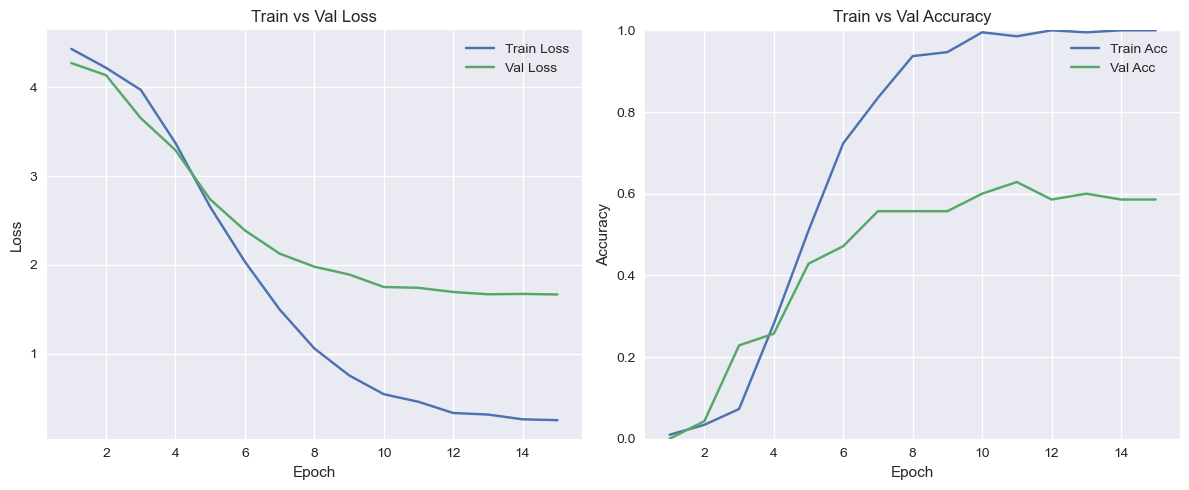

In [24]:
epochs = [log['epoch'] for log in train_log]
train_losses = [log['train_loss'] for log in train_log]
val_losses = [log['val_loss'] for log in train_log]
train_accs = [log['train_acc'] for log in train_log]
val_accs = [log['val_acc'] for log in train_log]

# Plot kurva loss/akurasi agar mudah inspeksi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Acc')
plt.plot(epochs, val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Val Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


## Evaluasi pada validation set
Menampilkan classification report dan confusion matrix menggunakan model terbaik.


In [25]:
# Muat checkpoint terbaik untuk evaluasi
best_artifact = torch.load(BASE_CFG["save_path"], map_location=device)
arch = best_artifact["arch"]
model = create_model(arch, num_classes=len(best_artifact["class_names"]))
model.load_state_dict(best_artifact["model"], strict=True)
model.to(device).eval()

val_transform = build_transforms(best_artifact["cfg"]["img_size"], best_artifact["cfg"]["aug"], is_train=False)
val_ds = FaceDataset(df_val, val_transform, has_label=True)
val_loader = DataLoader(val_ds, batch_size=best_artifact["cfg"]["batch_size"], shuffle=False, num_workers=BASE_CFG["num_workers"], pin_memory=True)

val_labels_all, val_preds_all = [], []  # tampung semua pred dan label
with torch.no_grad():
    for imgs, labels in val_loader:
        logits = model(imgs.to(device))
        preds = logits.argmax(dim=1).cpu().numpy()
        val_preds_all.extend(preds)
        val_labels_all.extend(labels.numpy())

val_acc = accuracy_score  # metrik utama untuk laporan(val_labels_all, val_preds_all)
print(f"Validation accuracy: {val_acc:.4f}")

labels_sorted = sorted(set(val_labels_all))
target_names = [best_artifact["class_names"][i] for i in labels_sorted]
print(classification_report(val_labels_all, val_preds_all, target_names=target_names, zero_division=0))

cm = confusion_matrix(val_labels_all, val_preds_all, labels=labels_sorted)
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Validation)')
plt.show()


TypeError: unsupported format string passed to function.__format__

## Inference helper + visualisasi
`load_best_model` + `recognize_face` menjalankan pipeline preprocessing hingga menghasilkan top-k label, sedangkan `visualize_prediction` menampilkan bounding box pada foto asli beserta label & confidence tertinggi.


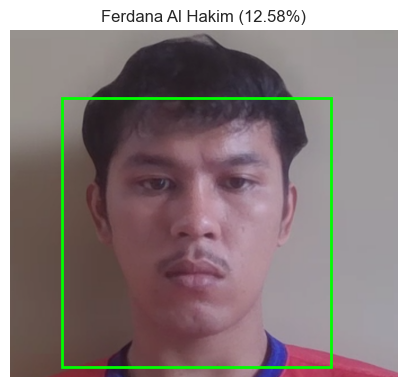

[('Ferdana Al Hakim', 0.12579143047332764),
 ('Joyapul Hanscalvin Panjaitan', 0.11267811805009842),
 ('Royfran Roger Valentino', 0.11200758814811707)]

In [35]:
# Loader artifact: buka checkpoint terbaik + transform evaluasi
def load_best_model(model_path=BASE_CFG["save_path"]):
    artifact = torch.load(model_path, map_location=device)
    model = create_model(artifact["arch"], num_classes=len(artifact["class_names"]))
    model.load_state_dict(artifact["model"], strict=True)
    model.to(device).eval()
    tfm = build_transforms(artifact["cfg"]["img_size"], artifact["cfg"]["aug"], is_train=False)
    return artifact, model, tfm


# Inference helper: preprocess satu foto dan kembalikan top-k label
def recognize_face(image_path, top_k=3, model_path=BASE_CFG["save_path"], return_meta=False):
    artifact, model, transform = load_best_model(model_path)

    bgr = read_image(image_path)
    if bgr is None:
        raise ValueError(f"Gagal membaca {image_path}")
    meta = detect_and_align(bgr)
    if meta is None:
        raise RuntimeError("Tidak ada wajah terdeteksi pada gambar.")

    processed = enhance_face(meta["aligned_rgb"])
    tensor = transform(image=processed)["image"].unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    top_idx = probs.argsort()[::-1][:top_k]
    preds = [(artifact["class_names"][i], float(probs[i])) for i in top_idx]

    if return_meta:
        meta = copy.deepcopy(meta)
        meta["orig_bgr"] = bgr
        meta["processed_rgb"] = processed
        meta["probs"] = probs
        meta["artifact"] = artifact
        return preds, meta
    return preds

# Visualisasi: tampilkan bounding box + label dengan confidence
def visualize_prediction(image_path, model_path=BASE_CFG["save_path"]):
    preds, meta = recognize_face(image_path, top_k=3, model_path=model_path, return_meta=True)
    best_name, best_conf = preds[0]

    rgb = cv2.cvtColor(meta["orig_bgr"], cv2.COLOR_BGR2RGB)
    x1, y1, x2, y2 = meta["bbox"]
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(rgb)
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="lime", linewidth=2)
    ax.add_patch(rect)
    ax.set_title(f"{best_name} ({best_conf:.2%})")
    ax.axis("off")
    plt.show()

    return preds

# Contoh pakai (ubah path sesuai foto baru):
recognize_face("dataset-train/test/boy2.png")
visualize_prediction("dataset-train/test/boy2.png")

In [27]:
import torch
ckpt = torch.load("face_deit_best.pth", map_location="cpu")
print(ckpt["cfg"])

{'arch': 'deit_tiny_patch16_224', 'img_size': 224, 'batch_size': 16, 'optimizer': 'adamw', 'lr': 0.0003, 'weight_decay': 0.05, 'aug': {'rrc_scale': (0.75, 1.0), 'hflip': 0.5, 'cj': (0.3, 0.3, 0.3, 0.05), 'rotate': 15}}
